2D Example demonstrating a spill and well separated by a stream.

In [14]:
import sys
import math
from io import StringIO
import os
import shutil
import platform
import numpy as np
from subprocess import check_output
import flopy
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

import config

print(np.__version__)

modelpth = os.path.join('Cara_model')
modelname = 'Spill'
mfexe = 'mfnwt'
mtexe = 'mt3dusgs'
if platform.system() == 'Windows':
    mfexe += '.exe'
    mtexe += '.exe'

# Instantiate MODFLOW model
mf = flopy.modflow.Modflow(modelname, version='mfnwt', exe_name=mfexe, 
                           model_ws=modelpth)

# Output Control: Create a flopy output control object
oc = flopy.modflow.ModflowOc(mf, stress_period_data={(0,0):['save head','save budget']})

# Newton-Rhapson Solver: Create a flopy nwt package object
headtol = 0.0001
fluxtol = 0.06
maxiterout = 200
thickfact = 1E-005
linmeth = 2
iprnwt = 1
ibotav = 0
nwt = flopy.modflow.ModflowNwt(mf, headtol=headtol, fluxtol=fluxtol, maxiterout=maxiterout,
                               thickfact=thickfact, linmeth=linmeth, iprnwt=iprnwt, ibotav=ibotav,
                               options='MODERATE')



1.14.1


Since this is a hyporthetical model, we will generate ground surface from some some equations

In [15]:
# Note that defining the ground surface this way allows to rediscretize on the fly if needed.
def topElev_Center(x,y):
    return ((-0.003 * x) + 260.) + (((-2E-9 * (x - 5000.)) + 1E-5) * (y + 1500.)**2)

# Model domain and grid definition
Lx = 10000.
Ly = 3000.
nlay = 1
nrow = 30
ncol = 100

delr = Lx / ncol
delc = Ly / nrow

xmax = ncol * delr
ymax = nrow * delc

X, Y = np.meshgrid(np.linspace(delr / 2, xmax - delr / 2, ncol),
                   np.linspace(ymax - delc / 2, 0 + delc / 2, nrow))

ibound = np.ones((nlay, nrow, ncol))

# modify the y values a bit
Y_mm = -1* np.flipud(Y)
topElev = topElev_Center(X, Y_mm)
botElev = np.zeros(topElev.shape)
strtElev= topElev - 1.

Steady = [True,False,False]
nstp = [1, 100, 200]
tsmult = [1, 1, 1]
perlen = [1, 36525, 73050]
    
# Create the discretization object
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, nper=3, delr=delr, delc=delc,
                               top=topElev, botm=botElev, laycbd=0, itmuni=4, lenuni=1,
                               steady=Steady, nstp=nstp, tsmult=tsmult, perlen=perlen)

Now instatiate the UPW package

In [16]:
laytyp = 1
layavg = 0
chani = 1.0
layvka = 0
hdry = -2e+20
iphdry = 1
hk = 0.1
hani = 1
vka = 0.01
ss = 0.00001
sy = 0.20

upw = flopy.modflow.ModflowUpw(mf, laytyp=laytyp, layavg=layavg, chani=chani, layvka=layvka,
                               ipakcb=53, hdry=hdry, iphdry=iphdry, hk=hk, hani=hani,
                               vka=vka, ss=ss, sy=sy)

# Instantiate BAS
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, hnoflo=hdry, strt=strtElev)

Now work on instantiating the boundary conditions

In [17]:
# Recharge Package: The total volume coming in from the upper and lower rows should 
# total 2000.0 on each side (4,000 total)
rech = np.zeros_like(topElev)
individual_cell_rate = 2000. / ncol / (delr*delc)
rech[0,:] = rech[-1,:] = individual_cell_rate
irch = np.zeros_like(rech)  # Remember, 0-based silliness in use
   
rch = flopy.modflow.ModflowRch(mf, nrchop=1, ipakcb=53, rech=rech, irch=irch)

In [18]:
# Evapotranspiration Package: The ET rate is 0.003 everywhere in the model, so rediscretization
# doesn't matter, can keep a constant rate.
nevtop = 1
evtr = 0.003
surf = topElev
exdp = 15
evt = flopy.modflow.ModflowEvt(mf, nevtop=nevtop, ipakcb=53, surf=surf, evtr=evtr, exdp=exdp)

In [19]:
# Streamflow Routing Package: Try and set up with minimal options in use
# 9 11 IFACE # Data Set 1: ISTCB1  ISTCB2
nstrm = 100
nss = 1
const = 1.283833650957E+005
dleak = 0.0001
istcb1 = 53
istcb2 = 0
isfropt = 0
nstrail = 10
isuzn = 1
nsfrsets = 30
irtflg = 1
numtim = 2
weight = 0.75
flwtol = 0.0001
segment_data = None
channel_geometry_data = None
channel_flow_data = None
dataset_5 = None
reachinput = False

# The next couple of lines set up the reach_data for the 30x100 hypothetical model.
# Will need to adjust the row based on which grid discretization we're doing.
# Ensure that the stream goes down one of the middle rows of the model.

# Determine the middle row and store in rMid (account for 0-base)
rMid = nrow//2 - 1

s1 = "k,i,j,iseg,ireach,rchlen,iface\n"
for y in range(ncol):
    #    layer +    row    +        col   +  iseg +   irch      +     rchlen     +    iface
    s1 += '0,' + str(rMid) + ',' + str(y) + ',1,' + str(y+1) + ',' + str(delr) + ',' + '0\n'

s1 = StringIO(s1)
reach_data = np.genfromtxt(s1, delimiter=',',names=True, dtype=[('k', '<f8'), ('i', '<f8'), ('j', '<f8'), ('iseg', '<f8'), ('ireach', '<f8'), ('rchlen', '<f8')])

# Will need to adjust the elevations of the upper and lower ends of the segment based on topElev array
# 5 m below ground surface (5 m of stream incision)
s2 = StringIO(u"nseg,icalc,outseg,iupseg,nstrpts,flow,runoff,etsw,pptsw,roughch,roughbk,cdpth,fdpth,awdth,bwdth,hcond1,thickm1,elevup,width1,depth1,hcond2,thickm2,elevdn,width2,depth2\n1,1,0,0,0,40000.0,0.0,0.0,0.0,0.028,0.0,0.0,0.0,0.0,0.0,1.0,1.0,254.899750,20.0,0.0,1.0,1.0,225.150250,20.0,0.0")
segment_data = np.genfromtxt(s2, delimiter=',',names=True)

# Adjust the elevations of the upstream and downstream ends of the segment
segment_data['elevup'] = topElev[rMid,0] - 5.
segment_data['elevdn'] = topElev[rMid,ncol-1] - 5.

# Be sure to convert segment_data to a dictionary keyed on stress period.
segment_data = np.atleast_1d(segment_data)
segment_data = {0: segment_data,
                1: segment_data,
                2: segment_data}

# There are 2 stress periods
dataset_5 = {0: [nss, 0, 0],
             1: [nss, 0, 0],
             2: [nss, 0, 0]}

channel_flow_data = {0: {1:[[ 1.0E+00, 1.0E+00, 2.5489975E+02, 2.0E+01],    #Data set 6b: HCOND1 THICKM1 ELEVUP WIDTH1
                            [ 1.0E+00, 1.0E+00, 2.2515025E+02, 2.0E+01]]},  #Data set 6c: HCOND2 THICKM2 ELEVDN WIDTH2
                     1: {2:[[ 1.0E+00, 1.0E+00, 2.5489975E+02, 2.0E+01],    #Data set 6b: HCOND1 THICKM1 ELEVUP WIDTH1
                            [ 1.0E+00, 1.0E+00, 2.2515025E+02, 2.0E+01]]},} #Data set 6c: HCOND2 THICKM2 ELEVDN WIDTH2

sfr = flopy.modflow.ModflowSfr2(mf, nstrm=nstrm, nss=nss, const=const, dleak=dleak,
                                ipakcb=53, istcb2=0, reach_data=reach_data, dataset_5=dataset_5,
                                segment_data=segment_data, channel_flow_data=channel_flow_data)

In [20]:
# Add a municipal pumping supply well
wel = flopy.modflow.ModflowWel(mf, ipakcb=53, stress_period_data = {1:[[0, 11, 74, -1.5e5],
                                                                       [0, 17, 25, 1.5e-5]]})

In [21]:
# Add the Link MT3D package for generating the linker file
lmt = flopy.modflow.ModflowLmt(mf, output_file_name='Spill.ftl', output_file_header='extended',
                               output_file_format='formatted', package_flows = ['sfr'])

In [22]:
mf.write_input()
mf.run_model()

FloPy is using the following  executable to run the model: c:\bin\mfnwt.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.3, 8/01/2017                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: Spill.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/10/24  2:43:01

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Str

 Solving:  Stress period:     2    Time step:    99    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   100    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     6    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     9    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Groundwater-Flow Eqn.

 Solving:  Stress period:     3    Time step:   107    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   108    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   109    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   110    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   111    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   112    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   113    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   114    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   115    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   116    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   117    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   118    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   119    Groundwater-Flow Eqn.

(True, [])

## Setup Transport Model

In [26]:
mt = flopy.mt3d.Mt3dms(modflowmodel=mf, modelname=modelname, model_ws=modelpth,
                       version='mt3d-usgs', namefile_ext='mtnam', exe_name=mtexe,
                       ftlfilename='Spill.ftl', ftlfree=True)

# BTN package
ncomp   =    1
lunit   =    'm'
sconc   =    0.0
prsity  =    sy
cinact  =   -1.0
thkmin  =    0.000001
nprs    =   -1
nprobs  =   10
nprmas  =   10
dt0     =  100.0
nstp    = nstp    # From DIS setup
mxstrn  = 5000
ttsmult =    1.0
ttsmax  =    0

#obs = [[0, 10, 15]]

btn = flopy.mt3d.Mt3dBtn(mt, MFStyleArr=True, DRYCell=True, lunit=lunit,
                         sconc=sconc, ncomp=ncomp, prsity=prsity, cinact=cinact,
                         thkmin=thkmin, nprs=nprs, nprobs=nprobs, 
                         chkmas=True,nprmas=nprmas, dt0=dt0,  
                         mxstrn=mxstrn, ttsmult=ttsmult, ttsmax=ttsmax)
# ADV package
mixelm =    0
percel =    1.0000
mxpart = 5000
nadvfd =    1      # (1 = Upstream weighting)

adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, percel=percel, mxpart=mxpart, 
                         nadvfd=nadvfd)

#GCG solver package
mxiter =   1
iter1  = 200
isolve =   3
ncrs   =   0
accl   =   1.000000
cclose =   1.00e-06
iprgcg =   5

gcg = flopy.mt3d.Mt3dGcg(mt, mxiter=mxiter, iter1=iter1, 
                         isolve=isolve, ncrs=ncrs, accl=accl, 
                         cclose=cclose, iprgcg=iprgcg)

# SSM
# ---

# First, get a dictionary that has the SSM itype for each of the boundary types.
itype = flopy.mt3d.Mt3dSsm.itype_dict()


mxss = 3002          # maximum number of boundary conditions
ssm_data = {}
#             kss,iss,jss,css,        ITYPE
ssm_data[0] = [(0, 11, 74,   0., itype['WEL']),
               (0, 17, 25,   0., itype['CC'])]          #Concstant Concentration
ssm_data[1] = [(0, 11, 74,   0., itype['WEL']),
               (0, 17, 25, 100., itype['CC'])]
ssm_data[2] = [(0, 11, 74,   0., itype['WEL']),
               (0, 17, 25,   0., itype['CC'])]

ssm = flopy.mt3d.Mt3dSsm(mt, mxss=mxss, stress_period_data=ssm_data)

# SFT
# ---
dispsf = 1
coldsf = 0
seg_len = np.unique(reach_data['iseg'], return_counts=True)
obs_sf = np.cumsum(seg_len[1])
obs_sf = obs_sf.tolist()

print(seg_len)
print('value: ' + str(obs_sf))

# In the first and last stress periods, concentration at the headwater is 0.0
sf_stress_period_data = {0: [0, 0, 0.0],
                         1: [0, 0, 0.0],
                         2: [0, 0, 0.0]}

gage_output = [None, None, 'CrnkNic.sftobs']

sft = flopy.mt3d.Mt3dSft(mt, nsfinit=100, mxsfbc=100, icbcsf=81, ioutobs=82,
                         isfsolv=1, cclosesf=1.0E-6, mxitersf=10, crntsf=1.0, iprtxmd=0,
                         coldsf=coldsf, dispsf=dispsf, nobssf=1, obs_sf=obs_sf,
                         sf_stress_period_data = sf_stress_period_data,
                         filenames=gage_output)



found 'rch' in modflow model, resetting crch to 0.0
found 'ets'/'evt' in modflow model, resetting cevt to 0.0
(array([1.]), array([100], dtype=int64))
value: [100]


### Run MT3D-USGS

In [27]:
mt.write_input()
mt.run_model()

FloPy is using the following  executable to run the model: c:\bin\mt3dusgs.exe

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.00.00] 
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: Spill.mtnam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    1.0000    

 Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

 STRESS PERIOD NO.    2

 TIME STEP NO.    1
 FROM TIME =   1.0000     TO    366.25    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   101.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1590E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1164E-08  [K,I,J]    1   19   26
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   201.00    
 Outer Iter.  1  Inner Iter.  1:  Max

 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   2857.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1490E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1863E-08  [K,I,J]    1   19   26
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   2923.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9706E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4441E-15  [K,I,J]    1   19   30

 TIME STEP NO.    9
 FROM TIME =   2923.0     TO    3288.2    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   3023.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1484E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1863E-08  [K,I,J]    1   19   26
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   3123.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1480E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1863E-08

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1358E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]    1   19   28
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   6775.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1354E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]    1   19   28
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   6875.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1351E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2910E-10  [K,I,J]    1   19   28
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   6940.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8802E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.   20
 FROM TIME =   6940.8     TO    7306.0    

 Transport Step:    1   Step Size:   100.0     Total El

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1210E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1421E-13  [K,I,J]    1   19   31
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   11524.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1207E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1421E-13  [K,I,J]    1   19   31
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   11624.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1204E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1421E-13  [K,I,J]    1   19   31
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   11689.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7842E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.   33
 FROM TIME =   11689.     TO    12054.    

 Transport Step:    1   Step Size:   100.0     Total El


 TIME STEP NO.   45
 FROM TIME =   16072.     TO    16437.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   16172.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1078E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3553E-14  [K,I,J]    1   19   32
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   16272.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1075E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3553E-14  [K,I,J]    1   19   32
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   16372.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1072E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2168E-18  [K,I,J]    1   19   35
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   16437.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6987E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000    

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3231E-26  [K,I,J]    1   18   41
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   20820.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6280E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.   58
 FROM TIME =   20820.     TO    21186.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   20920.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9601E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1578E-29  [K,I,J]    1   18   43
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   21020.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9578E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1735E-17  [K,I,J]    1   19   35
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   21120.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9555E-03

 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   25568.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5595E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.   71
 FROM TIME =   25568.     TO    25934.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   25668.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8554E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1616E-26  [K,I,J]    1   18   42
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   25768.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8533E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5049E-28  [K,I,J]    1   18   43
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   25868.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8512E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5049E-28

 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   29586.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5074E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.   82
 FROM TIME =   29586.     TO    29952.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   29686.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7758E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4039E-27  [K,I,J]    1   18   43
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   29786.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7739E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1262E-28  [K,I,J]    1   18   44
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   29886.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7720E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1262E-28

 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   33804.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7018E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3231E-26  [K,I,J]    1   18   43
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   33904.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7001E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3155E-29  [K,I,J]    1   18   45
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   33969.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4561E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.   94
 FROM TIME =   33969.     TO    34334.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   34069.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6973E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9861E-31

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1505E-35  [K,I,J]    1   19   50
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   38352.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1586E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.    6
 FROM TIME =   38352.     TO    38718.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   38452.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   38552.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:    3   Step Size:   100.0     Total El

 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   42205.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2351E-37  [K,I,J]    1   20   50
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   42305.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2351E-37  [K,I,J]    1   20   50
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   42370.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1586E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.   17
 FROM TIME =   42370.     TO    42735.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   42470.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2351E-37

 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   46588.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1881E-36  [K,I,J]    1   20   50
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   46688.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1881E-36  [K,I,J]    1   20   50
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   46753.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1586E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.   29
 FROM TIME =   46753.     TO    47118.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   46853.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1881E-36


 TIME STEP NO.   41
 FROM TIME =   51136.     TO    51501.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   51236.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1505E-35  [K,I,J]    1   20   50
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   51336.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1505E-35  [K,I,J]    1   20   50
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   51436.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3009E-35  [K,I,J]    1   20   50
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   51501.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1586E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   55984.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2407E-34  [K,I,J]    1   20   50
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   56084.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2407E-34  [K,I,J]    1   20   50
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   56184.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2407E-34  [K,I,J]    1   20   50
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   56250.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1586E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.   55
 FROM TIME =   5625

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1586E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.   67
 FROM TIME =   60632.     TO    60998.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   60732.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1926E-33  [K,I,J]    1   20   50
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   60832.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1926E-33  [K,I,J]    1   20   50
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   60932.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1926E-33  [K,I,J]    1   20   50
 Transport Step:    4   Step Size:   65.25     Total El

 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   65381.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1586E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.   80
 FROM TIME =   65381.     TO    65746.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   65481.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7704E-33  [K,I,J]    1   20   50
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   65581.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7704E-33  [K,I,J]    1   20   50
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   65681.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2429E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1541E-32

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2196E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6163E-32  [K,I,J]    1   20   50
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   69764.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1430E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.   92
 FROM TIME =   69764.     TO    70129.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   69864.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2186E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6163E-32  [K,I,J]    1   20   50
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   69964.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2181E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6163E-32  [K,I,J]    1   20   50
 Transport Step:    3   Step Size:   100.0     Total El

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1990E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1233E-31  [K,I,J]    1   20   50
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   73616.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1985E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1233E-31  [K,I,J]    1   20   50
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   73716.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1980E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3081E-32  [K,I,J]    1   20   51
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   73782.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1290E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.  103
 FROM TIME =   73782.     TO    74147.    

 Transport Step:    1   Step Size:   100.0     Total El

 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.  113
 FROM TIME =   77434.     TO    77799.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   77534.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1804E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4930E-31  [K,I,J]    1   20   50
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   77634.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1799E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4930E-31  [K,I,J]    1   20   50
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   77734.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1795E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4930E-31  [K,I,J]    1   20   50
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   77799.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1169E-02

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   81917.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1629E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1972E-30  [K,I,J]    1   20   50
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   82017.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1626E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1972E-30  [K,I,J]    1   20   50
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   82117.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1622E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1972E-30  [K,I,J]    1   20   50
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   82182.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1057E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.  126
 FROM TIME =   8218

 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.  138
 FROM TIME =   86565.     TO    86930.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   86665.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1467E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7889E-30  [K,I,J]    1   20   50
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   86765.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1464E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7889E-30  [K,I,J]    1   20   50
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   86865.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1461E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7889E-30  [K,I,J]    1   20   50
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   86930.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9522E-03

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6163E-32  [K,I,J]    1   20   53
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   91248.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1333E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3155E-29  [K,I,J]    1   20   50
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   91314.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8686E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.  151
 FROM TIME =   91314.     TO    91679.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   91414.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1328E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3155E-29  [K,I,J]    1   20   50
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   91514.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1326E-02

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   95796.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1216E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2465E-31  [K,I,J]    1   20   53
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   95896.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1214E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2465E-31  [K,I,J]    1   20   53
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   95996.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1212E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2465E-31  [K,I,J]    1   20   53
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   96062.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7897E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.  164
 FROM TIME =   9606

 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:  1.00645E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1108E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2524E-28  [K,I,J]    1   20   50
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:  1.00745E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1105E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2524E-28  [K,I,J]    1   20   50
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:  1.00810E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7206E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1

 TIME STEP NO.  177
 FROM TIME =  0.10081E+06 TO   0.10118E+06

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:  1.00910E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1102E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2524E-28


 TIME STEP NO.  189
 FROM TIME =  0.10519E+06 TO   0.10556E+06

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:  1.05293E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1011E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:  1.05393E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1008E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3155E-29  [K,I,J]    1   20   52
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:  1.05493E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1005E-02  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:  1.05558E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6544E-03  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000    

(False, [])

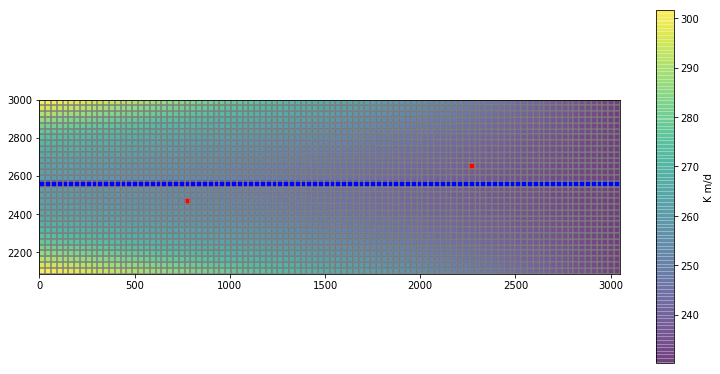

In [28]:
# plot some model attributes
fig = plt.figure(figsize=(13,13))
ax = plt.subplot(111,aspect="equal")
mm = flopy.plot.ModelMap(model=mf)
mm.plot_grid()
ax = mm.ax
mf.dis.top.plot(axes=[ax],colorbar="K m/d",alpha=0.5)
mf.wel.stress_period_data.plot(axes=[ax], kper=1)
mf.sfr.stress_period_data.plot(axes=[ax])